**Estudo em andamento**

As análises aqui apresentadas e resultados obtidos ainda não devem ser divulgados.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modelo-de-Jia-et-al-modificado-para-duas-cidades" data-toc-modified-id="Modelo-de-Jia-et-al.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modelo de Jia et al modificado para duas cidades</a></span><ul class="toc-item"><li><span><a href="#Sistema-de-equações-para-a-cidade-A" data-toc-modified-id="Populações-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Sistema de equações para Cidade A</a></span><li><span><a href="#Sistema-de-equações-para-a-cidade-B" data-toc-modified-id="Parâmetros-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Sistema de equações para Cidade B</a></span></li><li><span><a href="#Modelo-em-python" data-toc-modified-id="Modelo-em-python-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Representação por ação de massas para cidade A</a></span></li></ul></li><li><span><a href="#Transpondo-para-a-cidade-do-Rio-de-Janeiro" data-toc-modified-id="Transpondo-para-a-cidade-do-Rio-de-Janeiro-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Transpondo para a cidade do Rio de Janeiro</a></span><ul class="toc-item"><li><span><a href="#Dados-iniciais-para-o-Rio-de-Janeiro" data-toc-modified-id="Dados-iniciais-para-o-Rio-de-Janeiro-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Dados iniciais para o Rio de Janeiro</a></span></li><li><span><a href="#Parâmetros-para-a-cidade-do-Rio-de-Janeiro" data-toc-modified-id="Parâmetros-para-a-cidade-do-Rio-de-Janeiro-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Parâmetros para a cidade do Rio de Janeiro</a></span><ul class="toc-item"><li><span><a href="#Adaptando-parâmetros:" data-toc-modified-id="Adaptando-parâmetros:-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Adaptando parâmetros:</a></span></li></ul></li></ul></li><li><span><a href="#Simulação-19-dias-à-frente-para-validação" data-toc-modified-id="Simulação-19-dias-à-frente-para-validação-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulação 19 dias à frente para validação</a></span><ul class="toc-item"><li><span><a href="#Dados-da-cidade,-a-partir-de-29-de-Março" data-toc-modified-id="Dados-da-cidade,-a-partir-de-29-de-Março-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dados da cidade, a partir de 29 de Março</a></span></li><li><span><a href="#Comentário" data-toc-modified-id="Comentário-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Comentário</a></span></li></ul></li><li><span><a href="#Otimizando-parâmetros" data-toc-modified-id="Otimizando-parâmetros-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Otimizando parâmetros</a></span><ul class="toc-item"><li><span><a href="#Código" data-toc-modified-id="Código-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Código</a></span></li><li><span><a href="#Valores-iniciais-e-otimização" data-toc-modified-id="Valores-iniciais-e-otimização-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Valores iniciais e otimização</a></span><ul class="toc-item"><li><span><a href="#Comentário" data-toc-modified-id="Comentário-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Comentário</a></span></li></ul></li><li><span><a href="#Resultados-para-estes-novos-parâmetros" data-toc-modified-id="Resultados-para-estes-novos-parâmetros-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Resultados para estes novos parâmetros</a></span><ul class="toc-item"><li><span><a href="#Comportamento-da-curva" data-toc-modified-id="Comportamento-da-curva-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Comportamento da curva</a></span></li><li><span><a href="#Segundo-resultado:-estimativa-da-taxa-de-subnotificação" data-toc-modified-id="Segundo-resultado:-estimativa-da-taxa-de-subnotificação-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Segundo resultado: estimativa da taxa de subnotificação</a></span></li></ul></li></ul></li></ul></div>

# Modelo de Jia et al modificado para duas cidades

## Sistema de equações para a cidade A

$$
\begin{cases}
\displaystyle \frac{\mathrm{d}S_1}{\mathrm{d}t} &= -\beta_1 S_1\left(I_1 + \theta_1 A_1\right) - p_1 S_1 + \lambda_1 Q_1 - \mu_1 S_1 + \mu_2 S_2\\
\displaystyle \frac{\mathrm{d}Q_1}{\mathrm{d}t} &= p_1 S_1 - \lambda_1 Q_1\\
\displaystyle \frac{\mathrm{d}E_1}{\mathrm{d}t} &= \beta_1 S_1(I_1 + \theta_1 A_1) - \sigma_1 E_1 - \mu_1 E_1 + \mu_2 E_2\\
\displaystyle \frac{\mathrm{d}A_1}{\mathrm{d}t} &= \sigma_1(1- \rho_1)E_1 - \epsilon_{A_1} A_1 - \gamma_{A_1} A_1 - \mu_1 A_1 + \mu_2 A_2\\
\displaystyle \frac{\mathrm{d}I_1}{\mathrm{d}t} &= \sigma_1\rho_1 E_1 - \epsilon_{I_1} I_1 - \gamma_{D_1} D_1 - d_{D_1} D_1 - \delta_1 I_1 + \delta_2 I_2\\\
\displaystyle \frac{\mathrm{d}R_1}{\mathrm{d}t} &= \gamma_{A_1} A_1 + \gamma_{I_1} I_1 + \gamma_{D_1} D_1  - \mu_1 R_1 + \mu_2 R_2
\end{cases}
$$


### Sistema de Equações para a Cidade B

$$
\begin{cases}
\displaystyle\frac{\mathrm{d}S_2}{\mathrm{d}t} &= -\beta_2 S_2\left(I_2 + \theta_2 A_2\right) - p_2 S_2 + \lambda_2 Q_2 - \mu_2 S_2 + \mu_1 S_1\\
\displaystyle\frac{\mathrm{d}Q_2}{\mathrm{d}t} &= p_2 S_2 - \lambda_2 Q_2\\
\displaystyle\frac{\mathrm{d}E_2}{\mathrm{d}t} &= \beta_2 S_2(I_2 + \theta_2 A_2) - \sigma_2 E_2 - \mu_2 E_2 + \mu_1 E_1\\
\displaystyle\frac{\mathrm{d}A_2}{\mathrm{d}t} &= \sigma_2(1- \rho_2)E_2 - \epsilon_{A_2} A_2 - \gamma_{A_2} A_2 - \mu_2 A_2 + \mu_1 A_1\\
\displaystyle\frac{\mathrm{d}I_2}{\mathrm{d}t} &= \sigma_2\rho_2 E_2 - \epsilon_{I_2} I_2 - \gamma_{D_2} D_2 - d_{D_2} D_2 - \delta_2 I_2 + \delta_1 I_1\\
\displaystyle\frac{\mathrm{d}R_1}{\mathrm{d}t} &= \gamma_{A_1} A_1 + \gamma_{I_1} I_1 + \gamma_{D_1} D_1 - \mu_2 R_2 + \mu_1 R_1
\end{cases}
$$

### Representação por ação de massas da primeira cidade

$$
\begin{cases}
S_1 + I_1 \stackrel{\beta_1}{\longrightarrow} E_1 + I_1 \\
S_1 + A_1 \stackrel{\beta_1 \theta_1}{\longrightarrow} E_1 + A_1 \\
S_1 \stackrel{p_1}{\longrightarrow} Q_1 \\
Q_1 \stackrel{\lambda_1}{\longrightarrow} S_1 \\
E_1 \stackrel{\sigma_1 \rho}{\longrightarrow} I_1 \\
E_1 \stackrel{\sigma_1 (1-\rho)}{\longrightarrow} A_1 \\
I_1 \stackrel{\epsilon_{I_1}}{\longrightarrow} D_1 \\
A_1 \stackrel{\epsilon_{A_1}}{\longrightarrow} D_1 \\
I_1 \stackrel{\gamma_{I_1}}{\longrightarrow} R_1 \\
A_1 \stackrel{\gamma_{A_1}}{\longrightarrow} R_1 \\
D_1 \stackrel{\gamma_{D_1}}{\longrightarrow} R_1 \\
S_1 + E_1 + A_1 \stackrel{\mu_1}{\longrightarrow} S_2 + E_2 + A_2 \\
I_1 \stackrel{\delta_1}{\longrightarrow} I_2 \\
S_2 + E_2 + A_2 \stackrel{\mu_2}{\longrightarrow} S_1 + E_1 + A_1 \\
I_2 \stackrel{\delta_2}{\longrightarrow} I_1 \\
\end{cases}
$$

## Populações

### Sucetíveis e "em Quarentena"

- Parte da população sucetível pode migrar para quarentena (taxa $p$), e vice-versa (taxa $\lambda$).

### Expostos

- Parte da população sintomática que entrou em contato com infectados ou assintomáticos (taxa básica de contágio $\beta$)
- Uma parte destes irá progredir ao estágio seguinte da doença, a taxa de conversão $\sigma$:
    * Alguns como sintomáticos, outros como assintomáticos, em proporção $\rho : 1 - \rho$.
    * **Todos os expostos irão progredir para algum dos dois estados** neste modelo

### Assintomáticos, Infectados, Diagnosticados

- Tanto assintomáticos como infectados ainda estão "circulando" (pois não sabem que são portadores)
  e podem contaminar a população em geral.
- Assintomáticos:
    * menor taxa de contágio (approx 1/10 segundo o modelo original),
    * maior taxa de recuperação.
- Infectado:
    * maior taxa de contágio,
    * menor taxa de recuperação,
    * possibilidade de morte.
- Diagnosticado
    * Não contamina "mais ninguém", por hipótese, pois está isolado / em tratamento;
    * taxa intermediária de recuperação (entre infectados e assintomáticos),
    * menor taxa de morte do que infectados

### Recuperados

- Neste modelo, não são mais sucetíveis, nem contaminam mais ninguém.

## Parâmetros

- $\beta$: taxa básica de contágio de infectados -> sucetíveis
    * $\theta$: fator da taxa de contágio para assintomáticos -> sucetíveis
- $p$, $\lambda$: taxa de conversão entre população sucetível e em quarentena
- $\sigma$: taxa de evolução dos sintomas após contágio
    * $\rho$: proporção dos contágios que será assintomática
- $\epsilon_A$, $\epsilon_I$: proporção de assintomáticos / infectados que será diagnosticada
- $\gamma_A$, $\gamma_I$, $\gamma_D$: taxa de recuperação de assintomáticos / infectados / diagnosticados
- $d_I$ , $d_D$: taxa de morte para infectados e diagnosticados
- $\mu_1$: taxa com que um indivíduo sem sintomas (incluindo suscetíveis e recuperados) sai da cidade `1` e vai para a cidade `2`
- $\delta_1$: taxa com que um indivíduo infectado sintomático (não diagnosticado) sai da cidade `1` e vai para a cidade `2`

## Modelo em python

Separado em uma biblioteca dedicada, `jia_cidades.py`, onde as funções já existentes foram modificadas para receber condições iniciais e parâmetros de duas cidades. A modificação da função principal `F` se deu com a criação de uma nova função `G`, mantendo a `F` original.

In [1]:
from jia_cidades import multi_regime, F, G, new_diagn, new_deaths, multi_regime_cidades, tot_deaths

Aqui importamos também todas as bibliotecas ao qual o modelo necessita

In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from get_data import read_data, get_data

sns.set_style("darkgrid")

In [3]:
arquivo_conf = 'data_municipios/BIConfirmadosCOVID_RJ16abr.csv'
arquivo_obito = 'data_municipios/BIOBITOS_Confirmados_ERJ_16abr.csv'
df_confirmados = pd.read_csv(arquivo_conf, encoding = 'ISO-8859-1', delimiter = ';')
df_obitos = pd.read_csv(arquivo_obito, encoding = 'ISO-8859-1', delimiter = ';')
df_confirmados = read_data(df_confirmados, 'confirmados')
df_obitos = read_data(df_obitos, 'obitos')

# Rio de Janeiro

## Dados iniciais para o Rio de Janeiro

Usamos uma taxa de subnotificação de 8x, e uma taxa de exposição de 7x a população diagnosticada,
o que aproxima de forma bastante razoável a curva de diagnósticos e de óbitos.

Também é necessário estimar a taxa de assintomáticos nesta população,
que é maior do que para a doença já que a prioridade dos testes
é para aqueles que apresentaram sintomas mais graves.

In [4]:
# Taxa de subnotificação
taxa_subn   = 8
# Proporção de infectados assintomáticos
prop_assint = 0.80

In [5]:
# Dados para a cidade do Rio de Janeiro,
# IBGE 2019 (estimativa)
pop_Rio = 6718903
# 01 de Abril
diagn_Rio, recup_Rio = 697, 23
infect_Rio = diagn_Rio*(taxa_subn-1)*(1 - prop_assint)
assint_Rio = diagn_Rio*(taxa_subn-1)*prop_assint
expostos_Rio = diagn_Rio*7
quarentena_Rio = 0.6 * pop_Rio

sucetiveis_Rio = pop_Rio - (quarentena_Rio + expostos_Rio + assint_Rio + infect_Rio + diagn_Rio + recup_Rio)

## Parâmetros para a cidade do Rio de Janeiro

Usamos os parâmetros do artigo original para a cidade de Beijing,
em especial para obter aqueles referentes ao comportamento específico da doença
(progressão de estágios, taxa de recuperação, etc.).


- Fator de diagnóstico ($\epsilon$)
    * Para ser compatível com as hipóteses de população infectada inicial ~10x maior do que a diagnosticada
- Taxas de quarentena
    * Para corresponder a ~ 60% de quarentena da população no dia 29 de Março

In [6]:
# Idx       :         0,    1,     2,    3,     4,    5,     6,      7,    8,      9,     10,     11,     12    13     14
# Parâmetros:      beta,  theta,   p, lambda, sigma, rho,  epsA, gammaA, epsI, gammaI, deathI, gammaD, deathD   mu    delta
params_rio_base = (1e-7, 1/10, 1/4,    1/6,   1/7, 0.94, 1/100, 0.0996, 1/30, 0.0766, 0.0026, 0.0843, 0.0017, 1.3e-4, 2e-5)

## Dados Reais para o Rio de Janeiro

Dados de novos casos por dia de `Diagnosticados` e `Óbitos`

In [7]:
# Do dia 01/04 até o dia 15/04, dados da prefeitura
dados_Rio = [
    [114, 110, 60, 115, 86, 42, 141, 198, 184, 175, 97, 91, 326, 71, 126],
    [4,   7,  5,   2,  4,  5,  12,  14,   9,  10,  6,  8,   9, 25,  27]
]

# São Paulo

## Dados iniciais para São Paulo

Consideramos um primeiro caso olhando apenas para as cidades do Rio de Janeiro e de São Paulo, pelo fato de São Paulo ter mais dados disponíveis e assim ser mais fácil verificarmos se o modelo faz sentido.

Usamos a mesma taxa de subnotificação do RJ e exposição.

Os dados de `Diagnosticados` foram retirados do site da prefeitura: https://www.prefeitura.sp.gov.br/cidade/secretarias/saude/vigilancia_em_saude/doencas_e_agravos/coronavirus/index.php?p=295572

Nos dados da prefeitura de SP não há informações de `Recuperados`, então fizemos uma estimativa com base na mesma proporção de `Recuperados` do RJ



In [8]:
taxa_correcao_Rio = diagn_Rio / recup_Rio
print(f'Número de Recuperados Estimados na cidade: %d' % (int(1503/taxa_correcao_Rio)))

Número de Recuperados Estimados na cidade: 49


In [9]:
# Dados para a cidade de São Paulo
# IBGE 2019 (estimativa)
pop_SP = 12.2e6 
# 01 de Abril
diagn_SP, recup_SP = 1503, 49
infect_SP = diagn_SP*(taxa_subn-1)*(1 - prop_assint)
assint_SP = diagn_SP*(taxa_subn-1)*prop_assint
expostos_SP = diagn_SP*7
quarentena_SP = 0.6 * pop_SP

sucetiveis_SP = pop_SP- (quarentena_SP + expostos_SP + assint_SP + infect_SP + diagn_SP + recup_SP)

## Parâmetros para a cidade de São Paulo

Usamos os mesmos parâmetros da cidade do Rio de Janeiro, modificando $\beta$ para a população de SP.

In [10]:
# Idx       :         0,    1,     2,    3,     4,    5,     6,      7,    8,      9,     10,     11,     12    13     14
# Parâmetros:      beta,  theta,   p, lambda, sigma, rho,  epsA, gammaA, epsI, gammaI, deathI, gammaD, deathD   mu    delta
params_sp_base = (5e-8, 1/10, 1/4,    1/6,   1/7, 0.94, 1/100, 0.00996, 1/30, 0.0766, 0.0026, 0.0843, 0.0017, 7.2e-5, 1e-5)

## Dados Reais para São Paulo

Dados de novos casos por dia de `Diagnosticados` e `Óbitos`

In [11]:
# Do dia 01/04 até o dia 15/04
dados_SP = [ 
    [  17,  801,  408,  883,  142,  749,  634,  695,  547,  206,  220,
         26,  162, 1031,  865],
    [  24,   15,   33,    6,   25,
         53,   44,   45,   26,   10,   23,   11,   64,   43,   47]
] 

# Preparando os dados para o modelo

## Condição Inicial

A condição inicial das duas cidades é dada em uma lista concatenada `CI`, pois o metódo `solve_ivp` só aceita o parâmetro `y0` como uma lista de uma dimensão

In [12]:
# condições iniciais
CI_Rio = [sucetiveis_Rio, quarentena_Rio, expostos_Rio, assint_Rio, infect_Rio, diagn_Rio, recup_Rio]
CI_SP  = [sucetiveis_SP, quarentena_SP, expostos_SP, assint_SP, infect_SP, diagn_SP, recup_SP]
CI     = CI_Rio + CI_SP

## Parâmetros

Os parâmetros das duas cidades são dados em uma lista de listas de duas dimensões `params`, onde o primeiro elemento diz respeito à cidade A e o segundo elemento diz respeito à cidade B 

In [13]:
params = [[i,j] for i,j in zip(params_rio_base, params_sp_base)]

# Simulações

In [14]:
2e-3*pop_Rio + 1.3e-2*pop_Rio, 7.2e-3*pop_SP + 1e-3*pop_SP

(100783.545, 100040.0)

##  Rio de Janeiro $\times$ São Paulo

Estamos considerando uma modelagem onde estradas estão fechadas e temos um pequeno fluxo áreo entre as cidades, ajustando $mu$ e $delta$ para termos $1000$ pessoas por dia saindo e entrando das cidades 

In [15]:
print(f'População Saindo de SP por dia: %.2f' % (params_sp_base[-2]*pop_SP+params_sp_base[-1]*pop_SP))
print(f'População Saindo do RJ por dia: %.2f' % (params_rio_base[-2]*pop_Rio+params_rio_base[-1]*pop_Rio))

População Saindo de SP por dia: 1000.40
População Saindo do RJ por dia: 1007.84


In [16]:
T_fim = len(dados_Rio[0])

start = dt.datetime.strptime("01-04-2020", "%d-%m-%Y")
then = start + dt.timedelta(days=T_fim)
days = mdates.drange(start,then,dt.timedelta(days=1))

In [17]:
# Supondo mantida a quarentena
f_rio_base = lambda t,v: G(t,v, params)
results_base = solve_ivp(f_rio_base, (1,T_fim), CI, t_eval=range(1,T_fim+1))

In [18]:
diagn = new_diagn(results_base.y, params)
deaths = new_deaths(results_base.y, params)

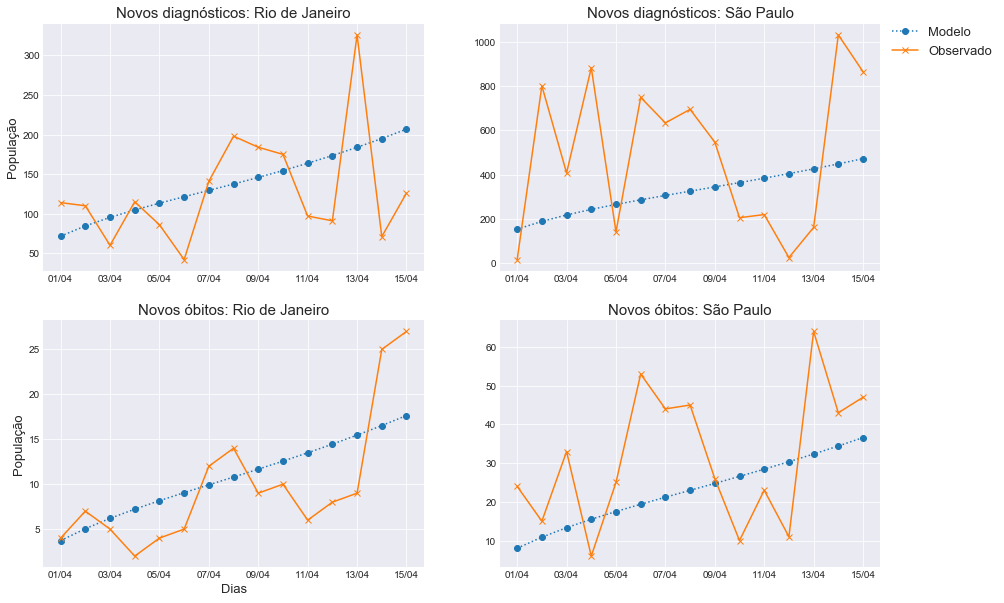

In [19]:
fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols=2, figsize=(15,10))

#diagn = new_diagn(results_base.y, params_rio_base)
ax1.plot(days, diagn[0],        'o:', label='Modelo')
ax1.plot(days, dados_Rio[0], 'x-', label='Observado')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax1.grid(color = 'white')
ax1.set_title('Novos diagnósticos: Rio de Janeiro', fontsize = 15)
ax1.set_ylabel('População', fontsize = 13)
cidade = 'São Paulo'
#diagn = new_diagn(results_base.y, params_rio_base)
ax2.plot(days, diagn[1],        'o:', label='Modelo')
ax2.plot(days, dados_SP[0], 'x-', label='Observado')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax2.grid(color = 'white')
ax2.set_title('Novos diagnósticos: ' + str(cidade), fontsize = 15)

ax3.plot(days, deaths[0],       'o:', label = 'Modelo')
ax3.plot(days, dados_Rio[1], 'x-', label='Observado')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax3.grid(color = 'white')
ax3.set_title('Novos óbitos: Rio de Janeiro', fontsize = 15)
ax3.set_ylabel('População', fontsize = 13)
ax3.set_xlabel('Dias', fontsize = 13)

ax4.plot(days, deaths[1],       'o:', label = 'Modelo')
ax4.plot(days, dados_SP[1], 'x-', label='Observado')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax4.grid(color = 'white')
ax4.set_title('Novos óbitos: ' + str(cidade), fontsize = 15)
ax3.set_xlabel('Dias', fontsize = 13)
ax1.legend(loc='center left', bbox_to_anchor=(2.2, 0.925), fontsize=13)

plt.show()

### Modificando Parâmetros: Abrindo tudo por dois dias

Consideramos agora o seguinte cenário: Todo o fluxo de pessoas é aberto entre as cidades durante dois dias, estimamos um fluxo de $100$ mil pessoas.

Além disso, quando abrimos o fluxo entre as cidades, a `Quarentena` dentro da própria cidade também termina, até que se feche o fluxo novamente, portanto modificamos também os parâmetros $p$ e $\lambda$ para $0$ e $1$ respectivamente

In [20]:
print(f'População Saindo de SP por dia: %.2f' % (7.2e-3*pop_SP + 1e-3*pop_SP))
print(f'População Saindo do RJ por dia: %.2f' % (2e-3*pop_Rio + 1.3e-2*pop_Rio))

População Saindo de SP por dia: 100040.00
População Saindo do RJ por dia: 100783.54


In [21]:
params_modif = [p[:] for p in params]
params_modif[-2][0], params_modif[-2][1] = 1.3e-3, 7.2e-3 # mu RJ e SP
params_modif[-1][0], params_modif[-1][1] = 2e-3,  1e-3# delta RJ e SP
params_modif[2][0], params_modif[2][1] = 0, 0 #p
params_modif[3][0], params_modif[3][1] = 1, 1  #lambda

dia_h = 5
dia_d = 7
dia_final = 30

t_par = [[dia_h, params], [dia_d, params_modif], [dia_final, params]] # abrir a quarentena por 15 dias
t_par_base = [[30,params]] # manter a quarentena do mesmo jeito

In [22]:
sol_multi_regime_modif = multi_regime_cidades(CI, 0, t_par)
sol_multi_regime_base = multi_regime_cidades(CI, 0, t_par_base)
ts = np.arange(len(sol_multi_regime_modif[0]))
legends = ['Suscetíveis', 'Quarentenados', 'Expostos', 'Assintomáticos', 'Infectados', 'Diagnosticados', 'Recuperados']
titles = ['Diferença entre os regimes (Rio de Janeiro)', 'Diferença entre os regimes (São Paulo)', 'Total de óbitos em cada regime',
         'Diferença de óbitos em cada regime']

C:\Users\biafa\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=10000000.0, top=10000000.0
  'bottom=%s, top=%s') % (bottom, top))


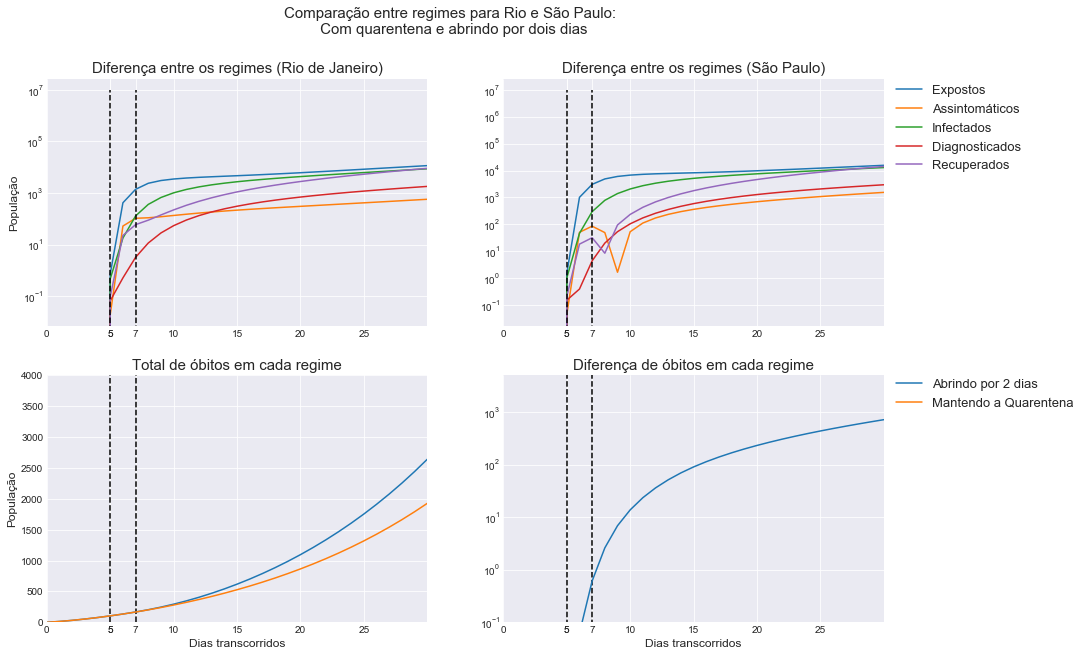

In [23]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows = 2,ncols = 2, figsize=(15,10))
fig.suptitle('Comparação entre regimes para Rio e São Paulo: \n Com quarentena e abrindo por dois dias', fontsize = 15)
for i in range(2,7):
    ax1.semilogy(ts, np.abs(sol_multi_regime_modif[i]-sol_multi_regime_base[i]), label = legends[i])
    ax2.semilogy(ts, np.abs(sol_multi_regime_modif[i+7]-sol_multi_regime_base[i+7]), label = legends[i])
    
eixos = [ax1,ax2, ax3, ax4]

for eixo in eixos:
    eixo.set_xticks(list(np.arange(0,dia_final, 5)) + [dia_h, dia_d])
    eixo.set_xlim(0, dia_final)
    eixo.plot([dia_h, dia_h], [0,1e7], '--', color = 'k')
    eixo.plot([dia_d, dia_d], [0,1e7], '--', color = 'k')
    eixo.grid(True)
    
for i,eixo in enumerate(eixos):
    eixo.set_title(titles[i], fontsize = 15)
ax3.plot(tot_deaths(sol_multi_regime_modif), label='Abrindo por ' + str(dia_d - dia_h)+ ' dias')
ax3.plot(tot_deaths(sol_multi_regime_base), label='Mantendo a Quarentena')

ax4.semilogy(tot_deaths(sol_multi_regime_modif) - tot_deaths(sol_multi_regime_base))
         

ax1.set_ylabel('População', fontsize = 12)
ax3.set_ylabel('População', fontsize = 12)

ax3.set_xlabel('Dias transcorridos', fontsize = 12)
ax4.set_xlabel('Dias transcorridos', fontsize = 12)

ax3.set_ylim([0,4000])
ax4.set_ylim([0.1, 5000])
ax1.legend(loc='center left', bbox_to_anchor=(2.2, 0.8), fontsize=13)
ax3.legend(loc='center left', bbox_to_anchor=(2.2, 0.925), fontsize=13)
plt.show()

# Niterói

## Dados iniciais para Niterói

Consideramos agora um estudo de caso entre as cidades do Rio de Janeiro e Nitéroi

Usamos a mesma taxa de subnotificação e exposição do RJ.

Os dados de `Diagnosticados` foram retirados do site do Estado: http://painel.saude.rj.gov.br/monitoramento/covid19.html

Nos dados de Niterói não há informações de `Recuperados`, então fizemos uma estimativa com base na mesma proporção de `Recuperados` do RJ

In [24]:
print(f'Número de Recuperados Estimados na cidade: %d' % (int(72/taxa_correcao_Rio)))

Número de Recuperados Estimados na cidade: 2


In [25]:
# Dados para a cidade de Niterói
# IBGE 2019 (estimativa)
pop_Nit = 487582 
# 29 de Março
diagn_Nit, recup_Nit = 72, 2
infect_Nit = diagn_Nit*(taxa_subn-1)*(1 - prop_assint)
assint_Nit = diagn_Nit*(taxa_subn-1)*prop_assint
expostos_Nit = diagn_Nit*7
quarentena_Nit = 0.6 * pop_Nit

sucetiveis_Nit = pop_Nit- (quarentena_Nit + expostos_Nit + assint_Nit + infect_Nit + diagn_Nit + recup_Nit)

## Parâmetros para a cidade de Niterói

Usamos os mesmos parâmetros da cidade do Rio de Janeiro, modificando $\beta$ para a população de Niterói.

In [26]:
# Idx       :         0,    1,     2,    3,     4,    5,     6,      7,    8,      9,     10,     11,     12    13     14
# Parâmetros:      beta,  theta,   p, lambda, sigma, rho,  epsA, gammaA, epsI, gammaI, deathI, gammaD, deathD   mu    delta
params_nit_base = (1.38e-6, 1/10, 1/4,    1/6,   1/7, 0.94, 1/100, 0.00996, 1/30, 0.0766, 0.0026, 0.0843, 0.0017, 3e-4, 0)

## Parâmetros para a cidade do Rio, considerando Niterói

In [27]:
# Idx       :         0,    1,     2,    3,     4,    5,     6,      7,    8,      9,     10,     11,     12    13     14
# Parâmetros:      beta,  theta,   p, lambda, sigma, rho,  epsA, gammaA, epsI, gammaI, deathI, gammaD, deathD   mu    delta
params_rio_nit_base = (1e-7, 1/10, 1/4,    1/6,   1/7, 0.94, 1/100, 0.0996, 1/30, 0.0766, 0.0026, 0.0843, 0.0017,2.2e-5, 0)

## Dados Reais para Niterói

Dados de novos casos por dia de `Diagnosticados` e `Óbitos`

In [28]:
dados_Nit = [get_data('NITEROI', df_confirmados, T_fim = len(dados_Rio[0]), T_start = '01-04-2020')[1], get_data('NITEROI', df_obitos, T_fim = len(dados_Rio[1]), T_start = '01-04-2020')[1]] ## Do dia 29/03 até o dia 12/04
dados_Nit

No total 6 dados foram inutilizados
No total 2 dados foram inutilizados


[[2, 2, 5, 1, 0, 7, 3, 0, 11, 0, 3, 2, 25, 0, 19],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0]]

##  Rio de Janeiro $\times$ Niterói

Estamos considerando uma modelagem onde a ponte Rio-Niterói está fechada para indivíduos não essenciais, ajustando $\mu$ e $\delta$ para termos $300$ pessoas por dia saindo e entrando das cidades 

# Preparando os dados para o modelo

## Condição Inicial

A condição inicial das duas cidades é dada em uma lista concatenada `CI`, pois o metódo `solve_ivp` só aceita o parâmetro `y0` como uma lista de uma dimensão

In [29]:
# condições iniciais
CI_Rio = [sucetiveis_Rio, quarentena_Rio, expostos_Rio, assint_Rio, infect_Rio, diagn_Rio, recup_Rio]
CI_Nit = [sucetiveis_Nit, quarentena_Nit, expostos_Nit, assint_Nit, infect_Nit, diagn_Nit, recup_Nit]
CI_Rio_Nit     = CI_Rio + CI_Nit

## Parâmetros

Os parâmetros das duas cidades são dados em uma lista de listas de duas dimensões `params`, onde o primeiro elemento diz respeito à cidade A e o segundo elemento diz respeito à cidade B 

In [30]:
params_rio_nit = [[i,j] for i,j in zip(params_rio_nit_base, params_nit_base)]

# Simulações

In [31]:
print(f'População Saindo de Niterói por dia: %.2f' % (params_nit_base[-2]*pop_Nit+params_nit_base[-1]*pop_Nit))
print(f'População Saindo do RJ por dia: %.2f' % (params_rio_nit_base[-2]*pop_Rio+params_rio_nit_base[-1]*pop_Rio))

População Saindo de Niterói por dia: 146.27
População Saindo do RJ por dia: 147.82


In [32]:
T_fim = len(dados_Nit[0])

start = dt.datetime.strptime("29-03-2020", "%d-%m-%Y")
then = start + dt.timedelta(days=T_fim)
days = mdates.drange(start,then,dt.timedelta(days=1))

In [33]:
# Supondo mantida a quarentena
f_rio_base = lambda t,v: G(t,v, params_rio_nit)
results_base = solve_ivp(f_rio_base, (1,T_fim), CI_Rio_Nit, t_eval=range(1,T_fim+1))

In [34]:
diagn = new_diagn(results_base.y, params_rio_nit)
deaths = new_deaths(results_base.y, params_rio_nit)

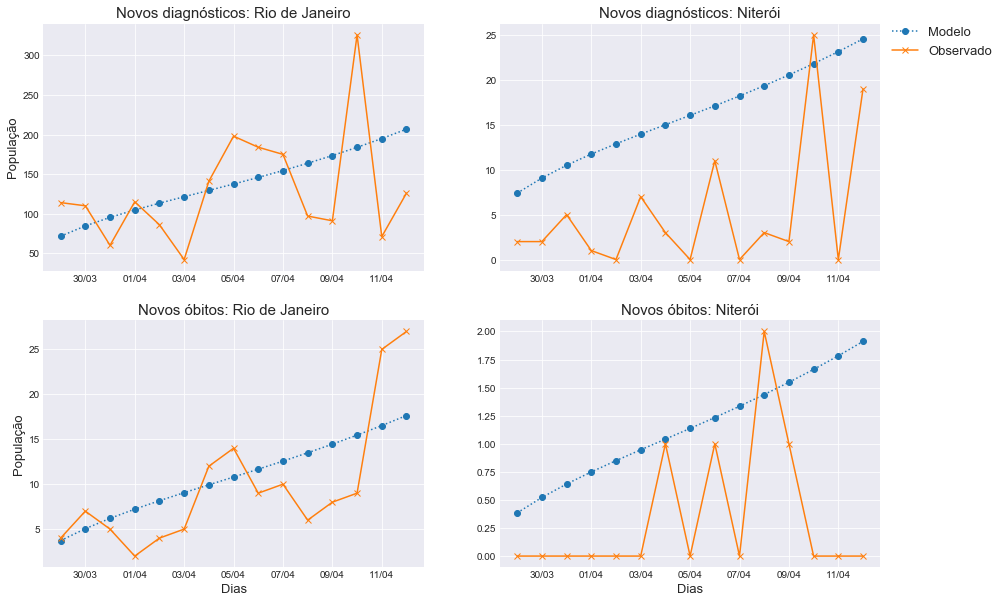

In [35]:
fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols=2, figsize=(15,10))

#diagn = new_diagn(results_base.y, params_rio_base)
ax1.plot(days, diagn[0],        'o:', label='Modelo')
ax1.plot(days, dados_Rio[0], 'x-', label='Observado')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax1.grid(color = 'white')
ax1.set_title('Novos diagnósticos: Rio de Janeiro', fontsize = 15)
ax1.set_ylabel('População', fontsize = 13)
cidade = 'Niterói'
#diagn = new_diagn(results_base.y, params_rio_base)
ax2.plot(days, diagn[1],        'o:', label='Modelo')
ax2.plot(days, dados_Nit[0], 'x-', label='Observado')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax2.grid(color = 'white')
ax2.set_title('Novos diagnósticos: ' + str(cidade), fontsize = 15)

ax3.plot(days, deaths[0],       'o:', label = 'Modelo')
ax3.plot(days, dados_Rio[1], 'x-', label='Observado')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax3.grid(color = 'white')
ax3.set_ylabel('População', fontsize = 13)
ax3.set_xlabel('Dias', fontsize = 13)
ax3.set_title('Novos óbitos: Rio de Janeiro', fontsize = 15)

ax4.plot(days, deaths[1],       'o:', label = 'Modelo')
ax4.plot(days, dados_Nit[1], 'x-', label='Observado')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax4.grid(color = 'white')
ax4.set_xlabel('Dias', fontsize = 13)
ax4.set_title('Novos óbitos: ' + str(cidade), fontsize = 15)
ax1.legend(loc='center left', bbox_to_anchor=(2.2, 0.925), fontsize=13)
plt.show()

### Modificando Parâmetros: Abrindo tudo por dois dias

Consideramos agora o seguinte cenário: Todo o fluxo de pessoas é aberto entre as cidades durante dois dias, estimamos um fluxo de $330$ mil pessoas.

Além disso, quando abrimos o fluxo entre as cidades, a `Quarentena` dentro da própria cidade também termina, até que se feche o fluxo novamente, portanto modificamos também os parâmetros $p$ e $\lambda$ para $0$ e $1$ respectivamente

In [36]:
### estamos considerando que todos os individuos que passam pela ponte vieram de niterói
print(f'População Saindo de Niterói por dia: %.2f' % (3.4e-1*pop_Nit + 2e-3*pop_Nit))
print(f'População Saindo do RJ por dia: %.2f' % (2.4e-2*pop_Rio + 1.4e-4*pop_Rio))

População Saindo de Niterói por dia: 166753.04
População Saindo do RJ por dia: 162194.32


In [37]:
params_rio_nit_modif = [p[:] for p in params_rio_nit]
params_rio_nit_modif[-2][0], params_rio_nit_modif[-2][1] = 2.4e-2, 3.4e-1##1.1e-2, 1.5e-1 # mu RJ e Nit
params_rio_nit_modif[-1][0], params_rio_nit_modif[-1][1] = 1.4e-4,  2e-3# delta RJ e Nit
params_rio_nit_modif[2][0], params_rio_nit_modif[2][1] = 0, 0 #p
params_rio_nit_modif[3][0], params_rio_nit_modif[3][1] = 1, 1  #lambda

dia_h = 5
dia_d = 7
dia_final = 30

t_par_rio_nit = [[dia_h, params_rio_nit], [dia_d, params_rio_nit_modif], [dia_final, params_rio_nit]] # abrir a quarentena por 15 dias
t_par_base_rio_nit = [[30,params_rio_nit]] # manter a quarentena do mesmo jeito

In [38]:
sol_multi_regime_modif = multi_regime_cidades(CI_Rio_Nit, 0, t_par_rio_nit)
sol_multi_regime_base = multi_regime_cidades(CI_Rio_Nit, 0, t_par_base_rio_nit)
ts = np.arange(len(sol_multi_regime_modif[0]))
legends = ['Suscetíveis', 'Quarentenados', 'Expostos', 'Assintomáticos', 'Infectados', 'Diagnosticados', 'Recuperados']
titles = ['Diferença entre os regimes (Rio de Janeiro)', 'Diferença entre os regimes (Niterói)', 'Total de óbitos em cada regime',
         'Diferença de óbitos em cada regime']

C:\Users\biafa\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=10000000.0, top=10000000.0
  'bottom=%s, top=%s') % (bottom, top))


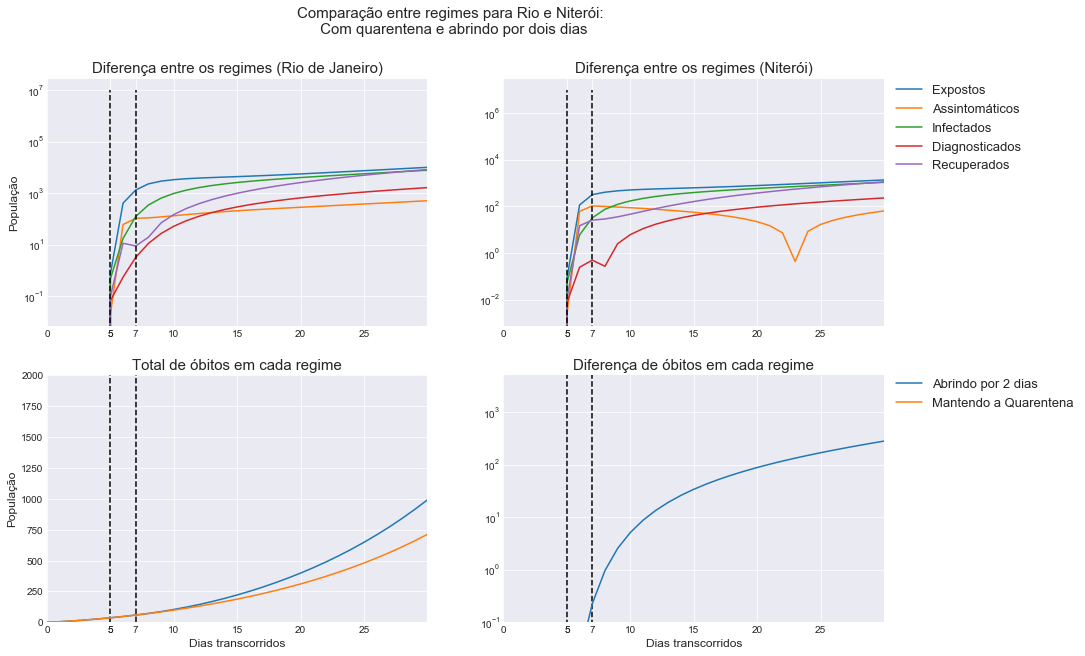

In [39]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows = 2,ncols = 2, figsize=(15,10))
fig.suptitle('Comparação entre regimes para Rio e Niterói: \n Com quarentena e abrindo por dois dias', fontsize = 15)
for i in range(2,7):
    ax1.semilogy(ts, np.abs(sol_multi_regime_modif[i]-sol_multi_regime_base[i]), label = legends[i])
    ax2.semilogy(ts, np.abs(sol_multi_regime_modif[i+7]-sol_multi_regime_base[i+7]), label = legends[i])
    
eixos = [ax1,ax2, ax3, ax4]

for eixo in eixos:
    eixo.set_xticks(list(np.arange(0,dia_final, 5)) + [dia_h, dia_d])
    eixo.set_xlim(0, dia_final)
    eixo.plot([dia_h, dia_h], [0,1e7], '--', color = 'k')
    eixo.plot([dia_d, dia_d], [0,1e7], '--', color = 'k')
    eixo.grid(True)
    
for i,eixo in enumerate(eixos):
    eixo.set_title(titles[i], fontsize = 15)
ax3.plot(tot_deaths(sol_multi_regime_modif), label='Abrindo por ' + str(dia_d - dia_h)+ ' dias')
ax3.plot(tot_deaths(sol_multi_regime_base), label='Mantendo a Quarentena')

ax4.semilogy(tot_deaths(sol_multi_regime_modif) - tot_deaths(sol_multi_regime_base))
         

ax1.set_ylabel('População', fontsize = 12)
ax3.set_ylabel('População', fontsize = 12)

ax3.set_xlabel('Dias transcorridos', fontsize = 12)
ax4.set_xlabel('Dias transcorridos', fontsize = 12)

ax3.set_ylim([0,2000])
ax4.set_ylim([0.1, 5000])
ax1.legend(loc='center left', bbox_to_anchor=(2.2, 0.8), fontsize=13)
ax3.legend(loc='center left', bbox_to_anchor=(2.2, 0.925), fontsize=13)
plt.show()